In [86]:
#%pip install ase==3.22.1
#%pip install numpy==1.24.4
#%pip install dscribe==2.5.0
#%pip install scipy

In [87]:
from ase.io import read
from ase import Atoms
import os
import glob

folder_path = './factor/'
file_list = sorted(glob.glob(os.path.join(folder_path, '*POSCAR'))) 

atoms_list = []
stype = []
for struc in file_list:
    if "c1" in struc:
        stype.append("red")
    elif "c2" in struc:
        stype.append("blue") 
    elif "c3" in struc:
        stype.append("green")  
    elif "c4" in struc:
        stype.append("black")
    elif "c5" in struc:
        stype.append("pink")
    else:
        stype.append("orange")

    atoms = read(struc,format='vasp')
    atoms_list.append(atoms)
    #supercell = atoms.repeat((2, 1, 1))
    #atoms_list.append(supercell)
    #print(f"Loaded: {struc}")
    
n_struc = len(atoms_list)
print(f"Total files loaded: {n_struc}")
print(f"stype loaded {len(stype)} items")


Total files loaded: 100
stype loaded 100 items


In [88]:
#Parameters setting
r_cut=5
n_max=4
l_max=4
print(atoms[0])

Atom('Cu', [np.float64(1.2049636102585926), np.float64(4.505342538050318), np.float64(4.38718669334603)], index=0)


In [89]:
species = list(set(atoms.get_chemical_symbols()))
print(species)

['Au', 'Cu']


# Create average vector for each substance

In [90]:
import numpy as np
from dscribe.descriptors import SOAP
from ase import Atoms

energy = []
soap_vectors = []
all_atoms = []

average_soap = SOAP(
    species=species,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    average="inner",
    sparse=False,
    periodic=True
)

for cid in atoms_list:
    #print(cid)
    try:
        atoms = cid
    except KeyError:
        print(f"CID {cid} not found, skip")
        continue
    soap_vectors.append(average_soap.create(atoms))
    #all_atoms.append(atoms)
soap_array = np.array(soap_vectors)

In [91]:
atoms_bm_standard = read("./standard/CuAu_Stn2_POSCAR")
average_bm = average_soap.create(atoms_bm_standard)


In [92]:
from ase.io import read
from scipy.spatial.distance import euclidean, cosine
import numpy as np

import math

def cos_sim(p, q):
    return 1-(np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q)))

third_smallest = 0
second_smallest = 0
smallest = 0
    
# 2. Iterate through soap_array (a list or array of SOAP vectors)
euclidean_distances = []
cosine_similarities = []
close_to_BM = []
close_to_BM_ID = []

for i, soap_vec in enumerate(soap_array):
    # Ensure vectors are flattened if necessary
    vec = np.ravel(soap_vec)
    ref = np.ravel(average_bm)

    # Euclidean distance
    euclid = euclidean(ref, vec)
    euclidean_distances.append(euclid)

    cosine_sim = cos_sim(ref, vec)
    cosine_similarities.append(cosine_sim)


# Optional: Convert to NumPy arrays for easy plotting/processing
euclidean_distances = np.array(euclidean_distances)
cosine_similarities = np.array(cosine_similarities)

# Example output
print('Euclid Value:',len(euclidean_distances))
print('Cosine Value:',len(cosine_similarities))


Euclid Value: 100
Cosine Value: 100


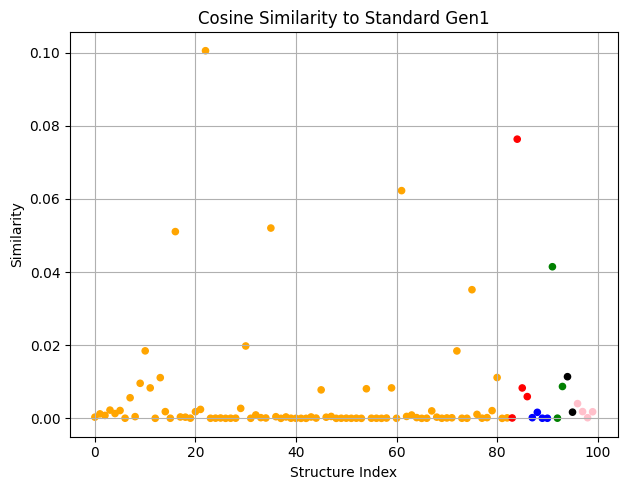

In [96]:
import matplotlib.pyplot as plt

x = np.arange(len(euclidean_distances))  # 各構造のインデックス

plt.figure(figsize=(12, 5))


# 2. Cosine Similarity
plt.subplot(1, 2, 2)
plt.scatter(x, cosine_similarities, marker='o', c=stype,s=20)
plt.title('Cosine Similarity to Standard Gen1')
plt.xlabel('Structure Index')
plt.ylabel('Similarity')
plt.grid(True)

plt.tight_layout()
plt.show()


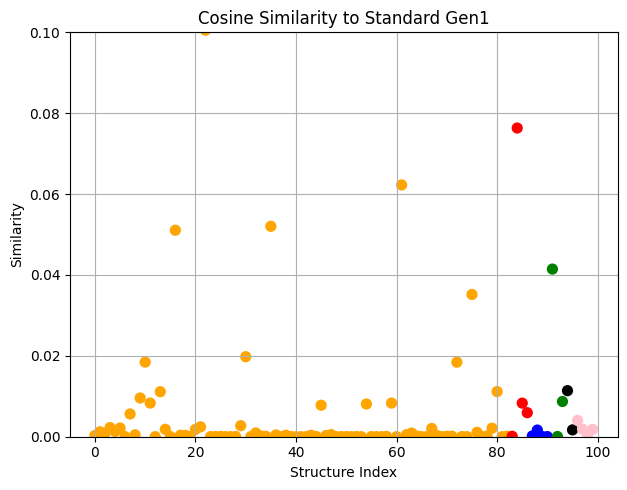

In [94]:
import matplotlib.pyplot as plt

x = np.arange(len(euclidean_distances))  # 各構造のインデックス

plt.figure(figsize=(12, 5))


# 2. Cosine Similarity
plt.subplot(1, 2, 2)
plt.scatter(x, cosine_similarities, marker='o', c=stype,s=50)
plt.title('Cosine Similarity to Standard Gen1')
plt.xlabel('Structure Index')
plt.ylabel('Similarity')
plt.grid(True)

plt.tight_layout()
plt.ylim([0, 0.10])
plt.show()

In [95]:

smallest_items = []
def smallest(arr,n):
  for i, number in enumerate(arr):
    # If the list isn't full yet, just add the new item.
    if len(smallest_items) < n:
      smallest_items.append((number, i))
      # Sort this small list after adding to keep the largest at the end
      # A simple bubble sort is used here to avoid the built-in sorted()
      for j in range(len(smallest_items) - 1, 0, -1):
        if smallest_items[j][0] < smallest_items[j-1][0]:
          smallest_items[j], smallest_items[j-1] = smallest_items[j-1], smallest_items[j]
        else:
          break
      continue

    # If the list is full, check if the new number is smaller than the largest item in our list
    # The largest item will be at the end of our sorted list (index n-1)
    if number < smallest_items[n-1][0]:
      # Replace the largest item with the new, smaller item
      smallest_items[n-1] = (number, i)
      # Re-sort the list to maintain order.
      for j in range(len(smallest_items) - 1, 0, -1):
        if smallest_items[j][0] < smallest_items[j-1][0]:
            smallest_items[j], smallest_items[j-1] = smallest_items[j-1], smallest_items[j]
        else:
            break
  result_indices = [item[1] for item in smallest_items]
  return result_indices
'''
print("Euclid ranking:")
for number,i in enumerate(smallest(euclidean_distances,3)):
  print(file_list[i],smallest_items[number][0])
'''
smallest_items = []
print("Cosine ranking:")
for number,i in enumerate(smallest(cosine_similarities,10)):
  print(file_list[i],smallest_items[number][0])
  

Cosine ranking:
./factor/99_POSCAR 2.3957955244124918e-06
./factor/50_POSCAR 3.7923784502735813e-06
./factor/81_POSCAR 5.090591685186219e-06
./factor/55_POSCAR 5.158922467107807e-06
./factor/68_POSCAR 5.2403682042623245e-06
./factor/54_POSCAR 5.26625772312439e-06
./factor/72_POSCAR 5.7684214509468035e-06
./factor/63_POSCAR 6.373186361874339e-06
./factor/53_POSCAR 1.2209452791678288e-05
./factor/39_POSCAR 1.2328995658839048e-05
